<a href="https://colab.research.google.com/github/Zahira11/NLP/blob/master/Name_entity_Recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition (NER) using LSTMs with Keras

# Task 1: Project Overview and Import Module

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: []


# Task 2: Load and Explore the NER Dataset

In [2]:
Essential info about tagged entities:

    geo = Geographical Entity
    org = Organization
    per = Person
    gpe = Geopolitical Entity
    tim = Time indicator
    art = Artifact
    eve = Event
    nat = Natural Phenomenon



SyntaxError: ignored

In [4]:

data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
print("unique words in corpus:", data['Word'].nunique())
print("unique tags in corpus:", data['Tag'].nunique())

unique words in corpus: 9216
unique tags in corpus: 17


In [6]:
words =  list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [7]:
tags =  list(set(data["Tag"].values))
num_tags = len(tags)

In [8]:
num_words, num_tags

(9217, 17)

# Task 3: Retrieve Sentences and Corresponsing Tags

In [9]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [10]:
getter =SentenceGetter(data)
sentences=getter.sentences


In [11]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

# Task 4: Define Mappings between Sentences and Tags

In [12]:
word2idx =  {w: i+1 for i, w in enumerate(words)}
tags2idx =  {t: i for i, t in enumerate(tags)}

In [13]:
word2idx

{'Deby': 1,
 'money': 2,
 'march': 3,
 'FARC': 4,
 'reorganize': 5,
 'Reigning': 6,
 'conservation': 7,
 'forming': 8,
 '36': 9,
 'times': 10,
 'influenza': 11,
 'pushing': 12,
 'caught': 13,
 'friends': 14,
 'penitentiary': 15,
 'quotas': 16,
 'Voters': 17,
 'one': 18,
 'H.I.V.': 19,
 'shrinking': 20,
 'announce': 21,
 'amendment': 22,
 'Rangoon': 23,
 'rally': 24,
 'cleaning': 25,
 'blood': 26,
 'messages': 27,
 'bastion': 28,
 'positive': 29,
 '38': 30,
 'borrowing': 31,
 'Zambian': 32,
 'Mutahida': 33,
 'Saud': 34,
 'Kashmiri': 35,
 'sentencing': 36,
 'Blondie': 37,
 'comprises': 38,
 'unity': 39,
 'Fleming': 40,
 'Persian': 41,
 'shaky': 42,
 'Gazprom': 43,
 'Beslan': 44,
 '60': 45,
 'Board': 46,
 'supporting': 47,
 'Development': 48,
 'Straw': 49,
 'assisted': 50,
 'Fidel': 51,
 'Friends': 52,
 'constitution': 53,
 'found': 54,
 'Joseph': 55,
 'zones': 56,
 'US': 57,
 'tribesmen': 58,
 'Tokyo': 59,
 'stability': 60,
 'sway': 61,
 '56': 62,
 '37': 63,
 'team': 64,
 'model': 65,
 '

# Task 5: Padding Input Sentences and Creating Train/Test SplitsÂ¶

(array([  2.,   0.,  11.,  21.,  23.,  98.,  71., 160., 110., 107., 259.,
        125., 150., 310., 176., 317., 167., 150., 255., 128., 102., 175.,
         68., 106.,  34.,  34.,  54.,  11.,  37.,   4.,   9.,   6.,   5.,
          3.,   6.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  2.38,  3.76,  5.14,  6.52,  7.9 ,  9.28, 10.66, 12.04,
        13.42, 14.8 , 16.18, 17.56, 18.94, 20.32, 21.7 , 23.08, 24.46,
        25.84, 27.22, 28.6 , 29.98, 31.36, 32.74, 34.12, 35.5 , 36.88,
        38.26, 39.64, 41.02, 42.4 , 43.78, 45.16, 46.54, 47.92, 49.3 ,
        50.68, 52.06, 53.44, 54.82, 56.2 , 57.58, 58.96, 60.34, 61.72,
        63.1 , 64.48, 65.86, 67.24, 68.62, 70.  ]),
 <a list of 50 Patch objects>)

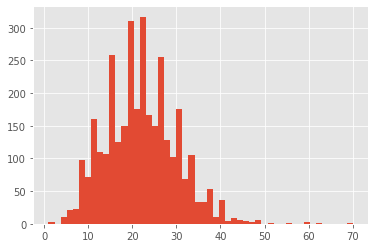

In [14]:
plt.hist([len(s) for s in sentences], bins = 50)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
x = [[word2idx[w[0]] for w in s] for s in sentences]
x =  pad_sequences(maxlen=max_len, sequences=x, padding='post', value= num_words-1)
y = [[tags2idx[w[2]] for w in s] for s in sentences]
y =  pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tags2idx["O"])
y = [to_categorical(i, num_classes=num_tags)for i in y]

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

# Task 6: Build and Compile a Bidirectional LSTM Model

In [17]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [18]:
input_word = Input(shape=(max_len,))
model =  Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model =  Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            460850    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 585,067
Trainable params: 585,067
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

# Task7: Train the Model 

In [21]:
%pip install install livelossplot

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [34]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]
history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=64,
    epochs= 10,
    verbose=1,
    callbacks=callbacks  
)

KeyError: ignored

In [35]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]


history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=64,
    epochs= 10,
    verbose=1,
)

Epoch 1/10
38/38 [==============================] - 9s 248ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.2071 - val_accuracy: 0.9692
Epoch 2/10
38/38 [==============================] - 9s 243ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.2039 - val_accuracy: 0.9693
Epoch 3/10
38/38 [==============================] - 9s 243ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.2155 - val_accuracy: 0.9688
Epoch 4/10
38/38 [==============================] - 9s 245ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.2134 - val_accuracy: 0.9691
Epoch 5/10
38/38 [==============================] - 9s 244ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.2122 - val_accuracy: 0.9692
Epoch 6/10
38/38 [==============================] - 9s 245ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.2155 - val_accuracy: 0.9692
Epoch 7/10
38/38 [==============================] - 9s 244ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.2200 - val_accuracy: 0.9696
Epoch 

# Task8: Evaluate Name entity Recognition Model

In [30]:
model.evaluate(x_test, np.array(y_test))

11/11 [==============================] - 0s 27ms/step - loss: 0.2112 - accuracy: 0.9697


[0.21123920381069183, 0.9696969985961914]

In [37]:
i= np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-"*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
A              O	O
coalition      O	O
of             O	O
six            O	O
parties        O	O
said           O	O
the            O	O
May            B-tim	B-tim
23             I-tim	O
election       I-tim	O
was            O	O
rigged         O	O
,              O	O
and            O	O
that           O	O
voters         O	O
and            O	O
opposition     O	O
candidates     O	O
were           O	O
harassed       O	O
.              O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts     O	O
broadcasts   